In [83]:
import pandas as pd
from datetime import datetime
import numpy as np
import statistics
import matplotlib.pyplot as plt


In [2]:
# original data source
data=pd.read_csv('/Users/yichuan/Desktop/Venmo project/data/venmoSample.csv')

In [3]:
data.head()

,user1,user2,transaction_type,datetime,description,is_business,story_id
0,1218774,1528945,payment,2015-11-27 02:48:19,Uber,False,5657c473cd03c9af22cff874
1,5109483,4782303,payment,2015-06-17 04:37:04,Costco,False,5580f9702b64f70ab0114e94
2,4322148,3392963,payment,2015-06-19 00:05:31,Sweaty balls,False,55835ccb1a624b14ac62cef4
3,469894,1333620,charge,2016-06-03 16:34:13,🎥,False,5751b185cd03c9af224c0d17
4,2960727,3442373,payment,2016-05-29 16:23:42,⚡,False,574b178ecd03c9af22cf67f4


# Data Processing

In [7]:
data['date']=[x.split(' ')[0] for x in data['datetime']]
data['time']=[x.split(' ')[1] for x in data['datetime']]
# strptime for further use
date_format = '%Y-%m-%d'
data['date_timestamp']=[datetime.strptime(str(x), date_format) for x in data['date']]
date_format = '%H:%M:%S'
data['time_timestamp']=[datetime.strptime(str(x), date_format) for x in data['time']]
data['year']=[x.year for x in data['date_timestamp']]

In [14]:
data['year'].value_counts()

2016    3817434
2015    2535158
2014     653769
2013      78488
2012       5387
2011          5
Name: year, dtype: int64

In [26]:
# subset data of 2016
data_2016=data[data['year']==2016]

-------

In [279]:
data_2016.shape

(3817434, 12)

In [145]:
data_2016['month']=[x.month for x in data_2016['date_timestamp']]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [278]:
#result.to_csv('/Users/yichuan/Desktop/Incubator-challenge/project/to_see_size.csv')

-------

In [147]:
# count number of transactions per user
# number of transactions = number of sending + number of receiving
data2=data_2016[['user2', 'user1', 'date_timestamp', 'month','time_timestamp' ]]

In [148]:
data2.columns=['user1', 'user2', 'date_timestamp', 'month','time_timestamp']

In [222]:
frames = [data_2016, data2]

data_2016_double = pd.concat(frames,sort=False)

In [223]:
data_2016_double.shape

(7634868, 5)

In [224]:
count_transaction=data_2016_double.groupby(['user1']).agg({'user2':'count'})

In [225]:
count_transaction.columns=['count_transaction']

In [226]:
trans_10=count_transaction[count_transaction['count_transaction']>=10]

In [227]:
trans_10.shape

(118965, 1)

In [228]:
# data of users with transactions>10   
# data size: 117.2 MB
result=data_2016_double.merge(trans_10, left_on=['user1'],right_index=True)


In [177]:
result.head()

,user1,user2,date_timestamp,time_timestamp,month,count_transaction
4,2960727,3442373,2016-05-29,1900-01-01 16:23:42,5,21
164504,2960727,2172670,2016-03-13,1900-01-01 00:23:46,3,21
442203,2960727,2358299,2016-01-24,1900-01-01 23:45:07,1,21
1011332,2960727,2190884,2016-04-26,1900-01-01 14:11:08,4,21
2038219,2960727,2390867,2016-06-18,1900-01-01 05:27:42,6,21


In [229]:
# users: 118,965
result.shape  # all transactions for users with 10 or more transactions

(1615954, 6)

# Plot One

Relationship of the number of transactions of users with that of their friends

In [230]:
# get number of transactions per month per user
count_month=data_2016_double.groupby(['user1','month']).agg({'user2':'count'})
count_month.columns=['count_user1']

In [233]:
# add information of number of transactions per month
# for both user1 and user2 (user2: view as friends)
result=result.merge(count_month,right_index=True,left_on=['user1','month'])
result.columns=['user1', 'user2', 'date_timestamp', 'time_timestamp', 'month',
       'count_transaction', 'count_u1_m']
result=result.merge(count_month,right_index=True,left_on=['user2','month'],how='left')
result.columns=['user1', 'user2', 'date_timestamp', 'time_timestamp', 'month',
       'count_transaction', 'count_u1_m', 'count_u2_m']

In [237]:
result.shape

(1615954, 8)

In [238]:
result.isnull().sum()

user1                0
user2                0
date_timestamp       0
time_timestamp       0
month                0
count_transaction    0
count_u1_m           0
count_u2_m           0
dtype: int64

------

In [239]:
# get number of transactions with each 'friend'
# get the total number of transactions of each 'friend'
count_friends=result.groupby(['user1','month','user2']).agg({'month':'count',
                                              'count_u2_m':'sum'})
count_friends.columns=['friend_c','friend_s']

In [244]:
count_friends['friend_t']=count_friends['friend_s']/count_friends['friend_c']

In [255]:
# get the mean of total number of transactions over all 'friends'
# per user, per month
user_friend=count_friends.groupby(['user1','month']).agg({'friend_t':'mean'})

In [256]:
user_friend=user_friend.merge(count_month,left_index=True, right_index=True,how='left')

In [253]:
user_friend.columns

Index(['friend_t', 'count_user1'], dtype='object')

In [257]:
user_friend.shape

(796261, 2)

In [268]:
user_friend

friend_t  count_user1
user1    month                        
767      2       1.500000            4
         3       1.000000            1
         4       2.250000            5
         5       2.500000            2
         6       1.000000            1
2210     1       2.000000            1
         2       1.500000            2
         4       1.000000            1
         5       1.500000            2
         6       1.500000            2
         7       1.000000            1
         9       3.000000            1
         10      1.250000            4
2504     1       1.000000            1
         3       1.500000            3
         4       1.500000            4
         5       1.000000            1
         6       1.000000            1
         7       2.000000            1
3756     1       2.000000            1
         2       1.000000            1
         3       1.500000            3
         7       2.500000            2
         8       2.000000            1
         9       1.000000            3
4262     1       3.333333            3
         2       3.000000            2
         3       2.000000            2
         4       1.000000            1
         5       2.000000            2
...                   ...          ...
11811424 7       1.800000            6
         8       4.000000            1
         9       6.000000            3
11830059 7       1.333333            6
         8       2.500000            2
         9       3.000000            1
         11      1.000000            1
11931332 7       9.333333            3
         8       6.250000            6
         9      17.000000            1
         11      8.000000            1
11972541 7       3.000000            2
         8       2.500000            3
         9       3.000000            2
         10      2.000000            2
         11      2.000000            2
12217247 7       1.400000            5
         8       1.000000            1
         9       3.333333            3
         10      1.500000            2
12686018 8       3.333333            3
         9       5.500000            2
         10      5.000000            6
13163741 8       2.375000            9
         9       1.666667            6
13254983 8       1.500000            2
         9       2.250000           12
         10      1.642857           14
13825362 9       4.000000            2
         10      2.250000            9

[796261 rows x 2 columns]

In [260]:
np.corrcoef(user_friend['friend_t'],user_friend['count_user1'])

array([[1.        , 0.15235966],
       [0.15235966, 1.        ]])

In [288]:
user_friend_plot=user_friend[user_friend['count_user1']<100]

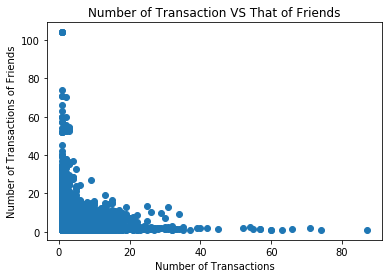

In [289]:
plt.scatter(user_friend_plot['count_user1'],user_friend_plot['friend_t'])
plt.xlabel('Number of Transactions')
plt.title('Number of Transaction VS That of Friends')
plt.ylabel('Number of Transactions of Friends')
plt.show()

* The effect of outliers and the small number of transactions per month per user are making the plot hared to read.
* Even if I filtered the outliers, things were not much better.
* So I decided to analyze based on number of transactions per year per user.

In [284]:
user_friend_plot=user_friend.groupby(['user1']).agg({'friend_t':'sum',
                                    'count_user1':'sum'})

In [285]:
user_friend_plot=user_friend_plot[user_friend_plot['count_user1']<600]

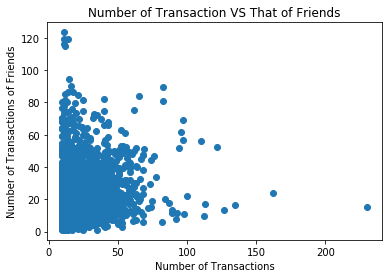

In [287]:
plt.scatter(user_friend_plot['count_user1'],user_friend_plot['friend_t'])
plt.xlabel('Number of Transactions')
plt.title('Number of Transaction VS That of Friends')
plt.ylabel('Number of Transactions of Friends')
plt.show()

* When analyzed based on number of transactions per year per user, the plot showed a positive relationship between number of transactions of users and that of their friends.

### Further analysis:
1. I would like to include more data. Then the analysis window could span to two or three years and make the analysis more solid.

2. Apply time series model on predicting the next period's number of transactions

# Plot Two

Investigate the number of transactions per user per period

In [292]:
q2=user_friend.groupby('month').agg({'friend_t':'count',
                                 'count_user1':'sum'})

In [294]:
q2.columns=['count_user','sum_transaction']

In [295]:
q2['per_u']=q2['sum_transaction']/q2['count_user']

In [298]:
q2=q2.reset_index()

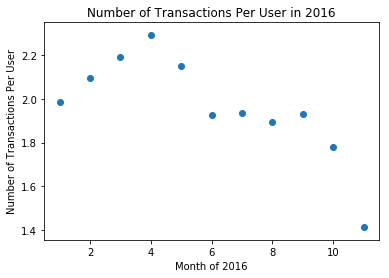

In [300]:
plt.scatter(q2['month'],q2['per_u'])
plt.xlabel('Month of 2016')
plt.title('Number of Transactions Per User in 2016')
plt.ylabel('Number of Transactions Per User')
plt.show()